In [ ]:
pip install biocircuits

     |████████████████████████████████| 44 kB 1.5 MB/s 


In [ ]:
import multiprocessing
import tqdm

import numpy as np
import scipy.stats as st
import numba

import biocircuits

# Plotting modules
import matplotlib.pyplot as plt
import bokeh.io
import bokeh.plotting

In [ ]:
def muestraDiscreta(prob):
    #Al azar da un index con probabilidad prob
    #Numero al azar
    n = np.random.rand()
    #Dar indice
    i = 0
    pSum = 0.0
    while pSum < n:
        pSum = pSum + prob[i]
        i = i+1
    return i-1

prob1 = np.array([0.1,0.3,0.4,0.05,0.15,1])



In [ ]:
def gillespieChoice(propensitiesFunction,propensities,population,time,args = ()):
    """Nos da la reaccion seleccionada al azar y el tiempo que se demoro en
    hacer la reaccion.
    """
    #Calcular propensities. 
    propensitiesFunction(propensities,population,time,*args)
    
    #Suma de las propensities.
    propsSum = propensities.sum()
    
    #Dar nuevo tiempo exponencial.
    t = np.random.exponential(1.0/propsSum)
    
    #Probabilidad discreta de cada reaccion:
    rDProb = propensities/propsSum
    
    #Sacar una reaccion de la distribucion
    reaction = muestraDiscreta(rDProb)
    
    return reaction, t

In [ ]:
"""
Tenemos la funcion que escoge nuestra reaccion. Ahora escribimos nuestro 
algoritmo de simulacion estocastico  (ASE)
"""

def gillespieSim1(propensityFunction, 
                  update,population0, 
                  timePoints, 
                  args =()):
    
    #Inicializar el output.
    outSol = np.empty((len(timePoints),update.shape[1]), dtype = int)
    
    #Inicializar y realizar la simulacion.
    timei = 1
    i = 0
    t = timePoints[0]
    population = population0.copy()
    outSol[0,:] = population
    propensities = np.zeros(update.shape[0])
    
    while i < len(timePoints):
        while t < timePoints[timei]:
            #Sacar evento y tiempo que paso para el evento.
            evento, dt = gillespieChoice(propensityFunction, propensities, population, t, args)
            
            #Actualizar la poblacion y el tiempo
            poblacionAnterior = population.copy()
            population += update[evento,:]
            
            t = t + dt
        #Actualizar indice
        i = np.searchsorted(timePoints >t,True)
        outSol[timei: min(i,len(timePoints))] = poblacionAnterior
        timei = i
    return outSol
            
    

In [ ]:
simple_update = np.array(
    [
        [1, 0],  # Make mRNA transcript
        [-1, 0],  # Degrade mRNA
        [0, 1],  # Make protein
        [0, -1],  # Degrade protein
    ],
    dtype=int,
)

def simple_propensity(propensities, population, t, beta_m, beta_p, gamma):
    """Updates an array of propensities given a set of parameters
    and an array of populations.
    """
    # Unpack population
    m, p = population

    # Update propensities
    propensities[0] = beta_m  # Make mRNA transcript
    propensities[1] = m  # Degrade mRNA
    propensities[2] = beta_p * m  # Make protein
    propensities[3] = gamma * p  # Degrade protein

In [ ]:
# Specify parameters for calculation
args = (10.0, 10.0, 0.4)
time_points = np.linspace(0, 50, 101)
population_0 = np.array([0, 0], dtype=int)
size = 2000

# Seed random number generator for reproducibility
np.random.seed(42)

# Initialize output array
samples = np.empty((size, len(time_points), 2), dtype=int)

# Run the calculations
for i in tqdm.tqdm(range(size)):
    samples[i, :, :] = gillespieSim1(
        simple_propensity, simple_update, population_0, time_points, args=args)

100%|██████████| 2000/2000 [11:07<00:00,  3.00it/s]


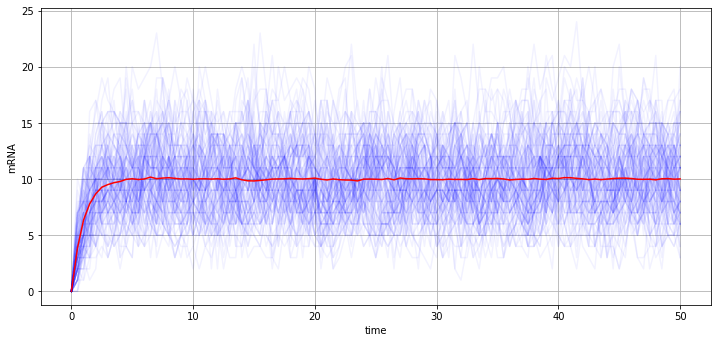

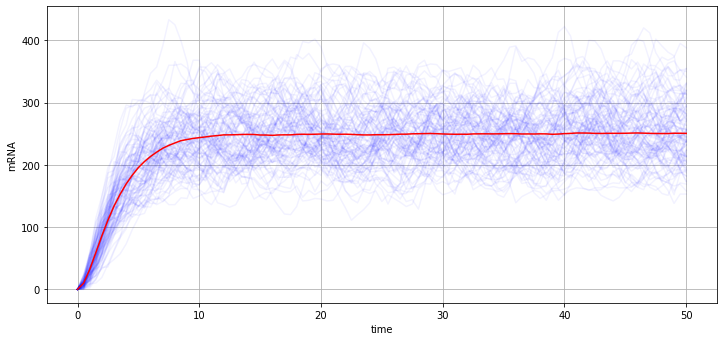

In [ ]:
plt.figure(figsize = (12,12))
plt.subplot(2,1,1)
plt.xlabel("time")
plt.ylabel("mRNA")
plt.grid()
for i in range(samples.shape[1]-1):
    plt.plot(time_points,samples[i,:,0],alpha=0.05, color ="blue")
plt.plot(time_points,samples[:, :, 0].mean(axis=0),color ="red")



plt.figure(figsize = (12,12))
plt.subplot(2,1,2)
plt.xlabel("time")
plt.ylabel("mRNA")
plt.grid()
for i in range(samples.shape[1]-1):
    plt.plot(time_points,samples[i,:,1],alpha=0.05,color = "blue")
plt.plot(time_points,samples[:, :, 1].mean(axis=0),color ="red")



In [ ]:
def propensityArray1(propensities,
                    population,
                    t,
                    k1, 
                    kn1,
                    k2,
                    k3,
                    kn3,
                    k4,
                    apos,
                    aneg
                   ):
    """
    Array de propensities que se actualiza ccon los parametros dados y con
    array de poblacion.
    """
    Fe, F, E1, FE1, Adh, E2, AdhE2,  Ak = population
    
    #Actualizar propensities.
    
    propensities[0] = aneg*F               # Fatty acid goes outside, Fatty inside goes down.
    propensities[1] = apos*Fe              # Fatty acid goes inside, Fatty inside goes up.
    propensities[2] = k1*F*E1              # Fatty inside goes down, enzyme 1 goes down, FE1 complex goes up.
    propensities[3] = kn1*(FE1)            # Fatty inside goes up, enzyme1 goes up, FE1 complex goes down.
    propensities[4] = k2*(FE1)             # FE1 complex goes down, enzyme1 goes up, Adh group is created.
    propensities[5] = k3*Adh*E2            # Adh goes down, enzyme2 goes down, AdhE2 complex gous up.
    propensities[6] = kn3*(AdhE2)          # AdhE2 complex goes down, enzyme2 goes up, Adh goes up.
    propensities[7] = k4*(AdhE2)           # AdhE2 complex goes down, enzyme2 goes up, Ak is created.

In [ ]:
"""
Columnas denotan
[F',F, E1, FE1, Adh, E2,AdhE2, Ak]
"""

update1 = np.array(
    [
        [1,-1,0,0,0,0,0,0],                    # Fatty acid goes outside, Fatty inside goes down.
        
        [-1,1,0,0,0,0,0,0],                    # Fatty acid goes inside, Fatty inside goes up.
        
        [0,-1,-1,1,0,0,0,0],                   # Fatty inside goes down, enzyme 1 goes down, FE1 complex goes up.
        
        [0,1,1,-1,0,0,0,0],                    # Fatty inside goes up, enzyme1 goes up, FE1 complex goes down.
        
        [0,0,1,-1,1,0,0,0],                    # FE1 complex goes down, enzyme1 goes up, Adh group is created.
        
        [0,0,0,0,-1,-1,1,0],                    # Adh goes down, enzyme2 goes down, AdhE2 complex goes up.
        
        [0,0,0,0,1,1,-1,0],                     # AdhE2 complex goes down, enzyme2 goes up, Adh goes up.
        
        [0,0,0,0,0,1,-1,1],                    # AdhE2 complex goes down, enzyme2 goes up, Ak is created.
    ],
    dtype = int
)

In [ ]:

# k1 =10
# kn1 = 1
# k2 = 20
# k3 =10
# kn3 = 1
# k4 = 20
# apos =10
# aneg= 1

args2 = (10, 1, 20, 10, 0.5, 20, 10, 0.5)
time_points = np.linspace(0, 50, 101)

"""
Population has the form
[F',F, E1, FE1, Adh, E2,AdhE2, Ak]
"""


population_0 = np.array([5000, 100,20,0,0,20,0,0], dtype=int)
size = 100

samples1 = np.empty((size, len(time_points), 8), dtype=int)
for i in tqdm.tqdm(range(size)):
    samples1[i, :, :] = gillespieSim1(propensityArray1, update1, population_0, time_points, args=args2)

  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
100%|██████████| 100/100 [03:04<00:00,  1.85s/it]


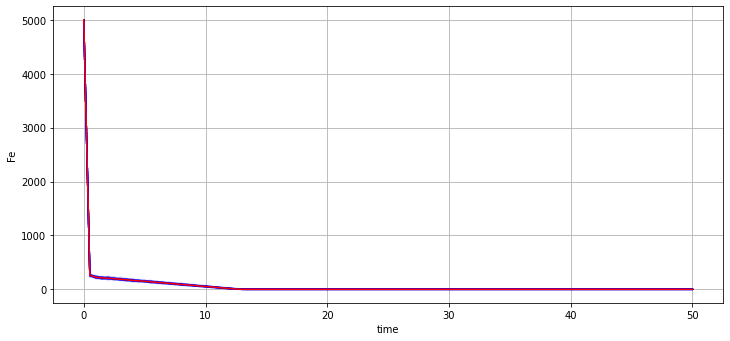

In [ ]:
plt.figure(figsize = (12,12))
plt.subplot(2,1,1)
plt.xlabel("time")
plt.ylabel("Fe")
plt.grid()
for i in range(samples1.shape[1]-1):
    plt.plot(time_points,samples1[i,:,0],alpha=0.05, color ="blue")
plt.plot(time_points,samples1[:, :, 0].mean(axis=0),color ="red")

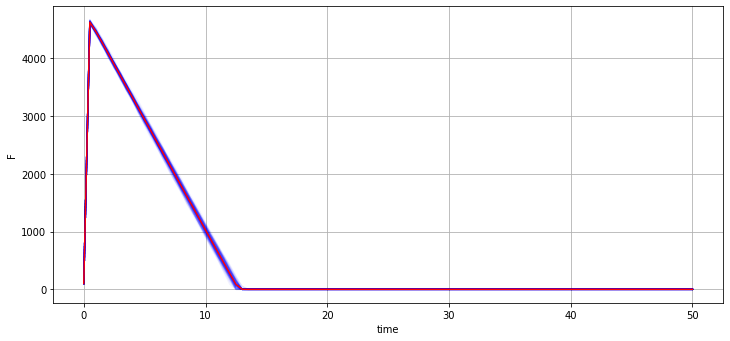

In [ ]:
plt.figure(figsize = (12,12))
plt.subplot(2,1,2)
plt.xlabel("time")
plt.ylabel("F")
plt.grid()
for i in range(samples1.shape[1]-1):
    plt.plot(time_points,samples1[i,:,1],alpha=0.05, color ="blue")
plt.plot(time_points,samples1[:, :, 1].mean(axis=0),color ="red")

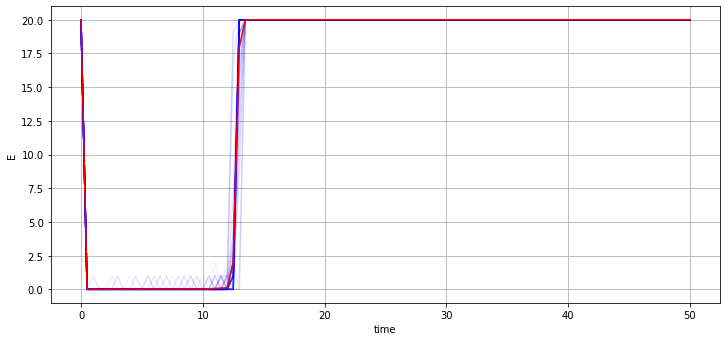

In [ ]:
plt.figure(figsize = (12,12))
plt.subplot(2,1,2)
plt.xlabel("time")
plt.ylabel("E")
plt.grid()
for i in range(samples1.shape[1]-1):
    plt.plot(time_points,samples1[i,:,2],alpha=0.05, color ="blue")
plt.plot(time_points,samples1[:, :, 2].mean(axis=0),color ="red")

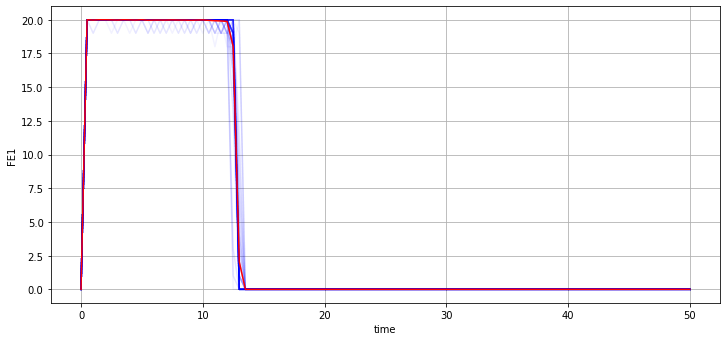

In [ ]:
plt.figure(figsize = (12,12))
plt.subplot(2,1,2)
plt.xlabel("time")
plt.ylabel("FE1")
plt.grid()
for i in range(samples1.shape[1]-1):
    plt.plot(time_points,samples1[i,:,3],alpha=0.05, color ="blue")
plt.plot(time_points,samples1[:, :, 3].mean(axis=0),color ="red")

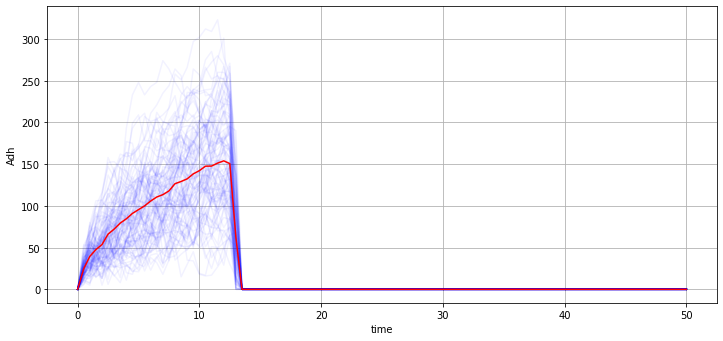

In [ ]:
plt.figure(figsize = (12,12))
plt.subplot(2,1,2)
plt.xlabel("time")
plt.ylabel("Adh")
plt.grid()
for i in range(samples1.shape[1]-1):
    plt.plot(time_points,samples1[i,:,4],alpha=0.05, color ="blue")
plt.plot(time_points,samples1[:, :, 4].mean(axis=0),color ="red")

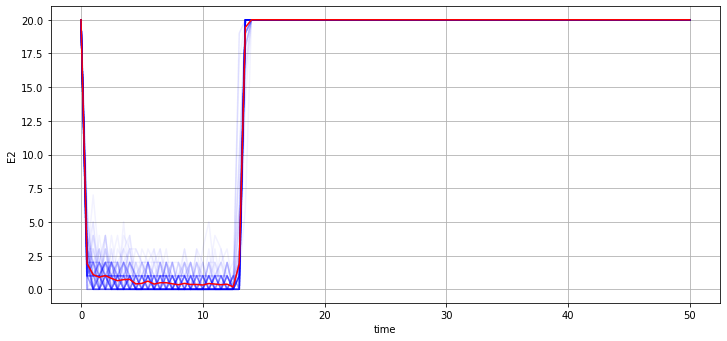

In [ ]:
plt.figure(figsize = (12,12))
plt.subplot(2,1,2)
plt.xlabel("time")
plt.ylabel("E2")
plt.grid()
for i in range(samples1.shape[1]-1):
    plt.plot(time_points,samples1[i,:,5],alpha=0.05, color ="blue")
plt.plot(time_points,samples1[:, :, 5].mean(axis=0),color ="red")


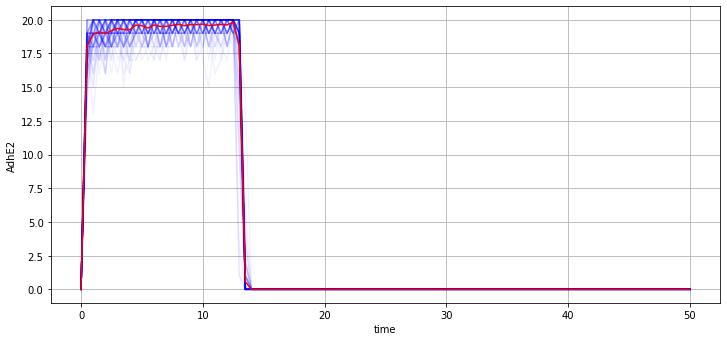

In [ ]:
plt.figure(figsize = (12,12))
plt.subplot(2,1,2)
plt.xlabel("time")
plt.ylabel("AdhE2")
plt.grid()
for i in range(samples1.shape[1]-1):
    plt.plot(time_points,samples1[i,:,6],alpha=0.05, color ="blue")
plt.plot(time_points,samples1[:, :, 6].mean(axis=0),color ="red")

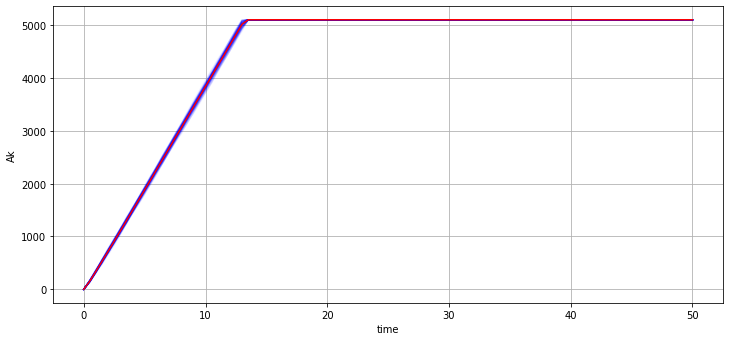

In [ ]:
plt.figure(figsize = (12,12))
plt.subplot(2,1,2)
plt.xlabel("time")
plt.ylabel("Ak")
plt.grid()
for i in range(samples1.shape[1]-1):
    plt.plot(time_points,samples1[i,:,7],alpha=0.05, color ="blue")
plt.plot(time_points,samples1[:, :, 7].mean(axis=0),color ="red")

In [ ]:


@numba.njit
def simple_propensity2(propensities, population, t, beta_m, beta_p, gamma):
    """Updates an array of propensities given a set of parameters
    and an array of populations.
    """
    # Unpack population
    m, p = population
    
    # Update propensities
    propensities[0] = beta_m      # Make mRNA transcript
    propensities[1] = m           # Degrade mRNA
    propensities[2] = beta_p * m  # Make protein
    propensities[3] = gamma * p   # Degrade protein



# Column 0 is change in m, column 1 is change in p
simple_update2 = np.array([[1, 0],   # Make mRNA transcript
                          [-1, 0],  # Degrade mRNA
                          [0, 1],   # Make protein
                          [0, -1]], # Degrade protein
                         dtype=np.int)

args = (10.0, 10.0, 0.4)
time_points = np.linspace(0, 50, 101)
population_0 = np.array([0, 0], dtype=int)
size = 100



In [ ]:


samples = biocircuits.gillespie_ssa(simple_propensity2, 
                                    simple_update2, 
                                    population_0, 
                                    time_points, 
                                    size=2000, 
                                    args=args,
                                    n_threads=4,
                                    progress_bar=True)



100%|██████████| 1000/1000 [00:12<00:00, 78.06it/s]


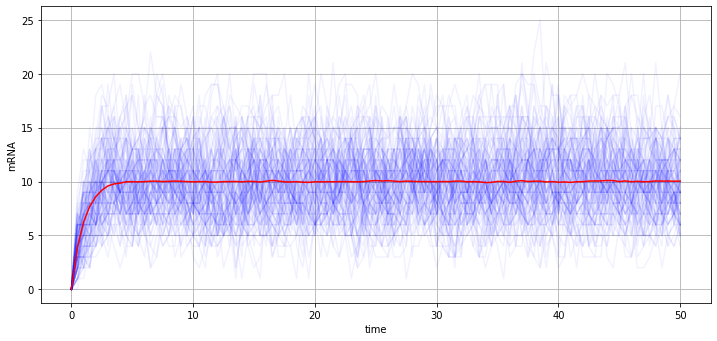

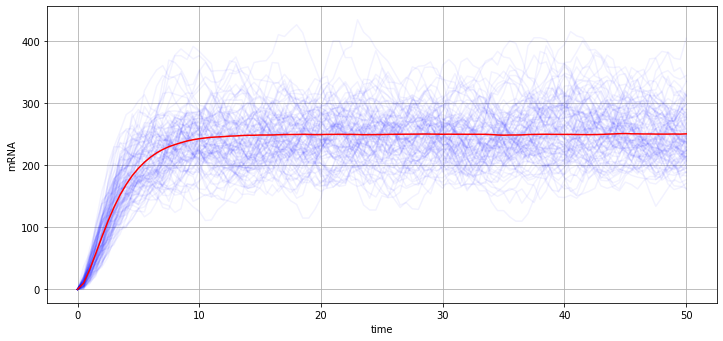

In [ ]:
plt.figure(figsize = (12,12))
plt.subplot(2,1,1)
plt.xlabel("time")
plt.ylabel("mRNA")
plt.grid()
for i in range(samples.shape[1]-1):
    plt.plot(time_points,samples[i,:,0],alpha=0.05, color ="blue")
plt.plot(time_points,samples[:, :, 0].mean(axis=0),color ="red")

plt.figure(figsize = (12,12))
plt.subplot(2,1,2)
plt.xlabel("time")
plt.ylabel("mRNA")
plt.grid()
for i in range(samples.shape[1]-1):
    plt.plot(time_points,samples[i,:,1],alpha=0.05,color = "blue")
plt.plot(time_points,samples[:, :, 1].mean(axis=0),color ="red")





In [ ]:
"""
Usemos ahora el paquete de biocircuits para realizar la simulacion. Gracias a threads, podemos hacer simulaciones en paralelo 
y optimizar.
"""

#Queremos definir uan concentracion afuera total.
cAfuera = 5*(10**5)

#Definamos

